In [1]:
#import liobraries 
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

## Load Data

In [3]:
#load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
        "rice_images",
        shuffle=True,
        image_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE
)

Found 3355 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names

In [5]:
len(dataset) #every element in dataset is a set of 32 images

105

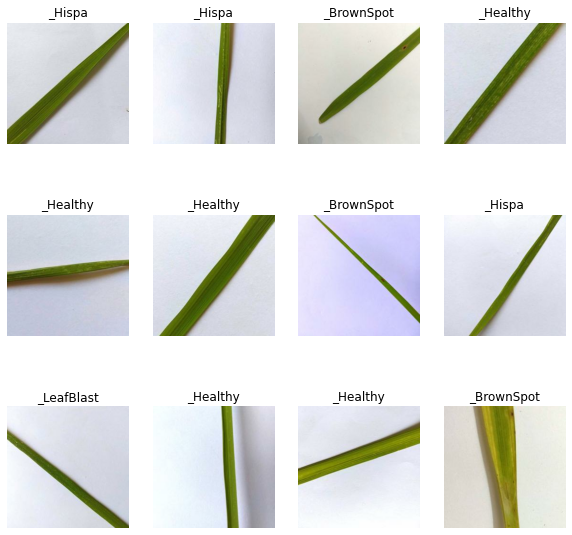

In [6]:
#exploring a single batch
plt.figure(figsize=(10,10)) #increase image area to 10x10
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])#display title
        plt.axis("off")
        #print(image_batch[0].shape)#exploration
        #print(label_batch.numpy())#covert to numpy

In [7]:
len(dataset)

105

# split dataset into train and test 
### 80% ==> training 
### 20% ==> 10% validation, 10% test

In [9]:
train_size = 0.8
len(dataset)*train_size

84.0

In [10]:
train_ds=dataset.take(84)
len(train_ds)

84

In [11]:
test_ds = dataset.skip(84)
len(test_ds)

21

In [12]:
val_size=0.1
len(dataset)*val_size

10.5

In [13]:
val_ds=test_ds.take(10)
len(val_ds)

10

In [14]:
test_ds = test_ds.skip(10)
len(test_ds)

11

In [8]:
#split dataset in function
def get_dataset_partition_tf (ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds) #dataset size
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size) #train size converted to intger to avoid float
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [10]:
len(train_ds)

84

In [11]:
len(val_ds)

10

In [1]:
len(test_ds)

NameError: name 'test_ds' is not defined

## Preprocessing

In [13]:
#cache will read image from disk and keep image in memeory for next iteration. 
#prefetch and cache to optimize our input pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) #buffer_size=tf.data.AUTOTUNE is to allow tf determine the batch size
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
#resize and rescale
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE), #resize new inputs 
    layers.experimental.preprocessing.Rescaling(1.0/255) #scale down RGB
])

In [15]:
#data_augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

## Build Model - CNN

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape), #google Conv2D for all arguement. 32=no. of layers
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    #flatten into an array of neurons
    layers.Flatten(),
    layers.Dense(64, activation='relu'), #dense layer of 64 neurons
    layers.Dense(n_classes, activation='softmax'), #softmax normalizes the prob of classes.  
])

model.build(input_shape=input_shape)

In [55]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_7 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (32, 60, 60, 64)         

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'] #track training process
)

In [26]:
#good to record the history of every epochs in params
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
84/84 [==============================] - 158s 2s/step - loss: 1.3002 - accuracy: 0.4409 - val_loss: 1.3179 - val_accuracy: 0.4375
Epoch 2/20
84/84 [==============================] - 123s 1s/step - loss: 1.2920 - accuracy: 0.4443 - val_loss: 1.2998 - val_accuracy: 0.4375
Epoch 3/20
84/84 [==============================] - 154s 2s/step - loss: 1.2881 - accuracy: 0.4454 - val_loss: 1.2507 - val_accuracy: 0.4906
Epoch 4/20
84/84 [==============================] - 160s 2s/step - loss: 1.1947 - accuracy: 0.5013 - val_loss: 1.1283 - val_accuracy: 0.5219
Epoch 5/20
84/84 [==============================] - 160s 2s/step - loss: 1.1468 - accuracy: 0.5158 - val_loss: 1.1492 - val_accuracy: 0.5312
Epoch 6/20
84/84 [==============================] - 122s 1s/step - loss: 1.1211 - accuracy: 0.5222 - val_loss: 1.1269 - val_accuracy: 0.5281
Epoch 7/20
84/84 [==============================] - 120s 1s/step - loss: 1.1494 - accuracy: 0.5125 - val_loss: 1.1483 - val_accuracy: 0.5406
Epoch 8/20
84

In [28]:
#test model with test_ds
scores = model.evaluate(test_ds)

11/11 [==============================] - 4s 326ms/step - loss: 1.1538 - accuracy: 0.5142


In [29]:
history #google variable output for arguements 

In [30]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 84}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
history.history['accuracy']

[0.44092434644699097,
 0.4442788064479828,
 0.44539692997932434,
 0.5013045072555542,
 0.515840470790863,
 0.5221766829490662,
 0.5124860405921936,
 0.5143495798110962,
 0.5270220041275024,
 0.5203130841255188,
 0.5303764343261719,
 0.5292583107948303,
 0.5333581566810608,
 0.528140127658844,
 0.5270220041275024,
 0.528140127658844,
 0.5348490476608276,
 0.5486395955085754,
 0.5482668876647949,
 0.5139768719673157]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

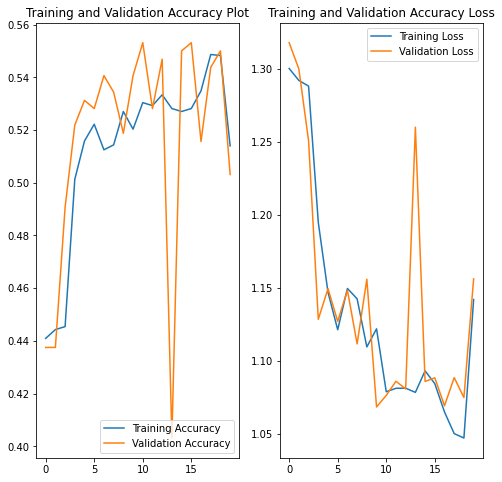

In [39]:
#plotting training and validation accuracy
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label ='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy Plot')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label ='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy Loss')
plt.show()

In [35]:
history.history['val_accuracy']

[0.4375,
 0.4375,
 0.4906249940395355,
 0.5218750238418579,
 0.53125,
 0.528124988079071,
 0.5406249761581421,
 0.534375011920929,
 0.518750011920929,
 0.5406249761581421,
 0.5531250238418579,
 0.528124988079071,
 0.546875,
 0.40312498807907104,
 0.550000011920929,
 0.5531250238418579,
 0.515625,
 0.543749988079071,
 0.550000011920929,
 0.503125011920929]

In [65]:
np.argmax([0.04980154,0.5683826,0.2425103,0.13930552])

1

first image to predict
actual label: _Healthy
prediction:  _Healthy


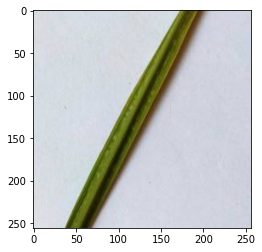

In [98]:
#make a prediction - 1 batch - test_ds

import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    #print(images_batch[0].numpy().astype('uint8'))
    #plt.imshow(images_batch[0].numpy().astype('uint8'))
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    #model is ready so call predict function 
    batch_prediction = model.predict(images_batch)
    print("prediction: ", class_names[np.argmax(batch_prediction[0])])
    

In [91]:
#prediction class vs confidence
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

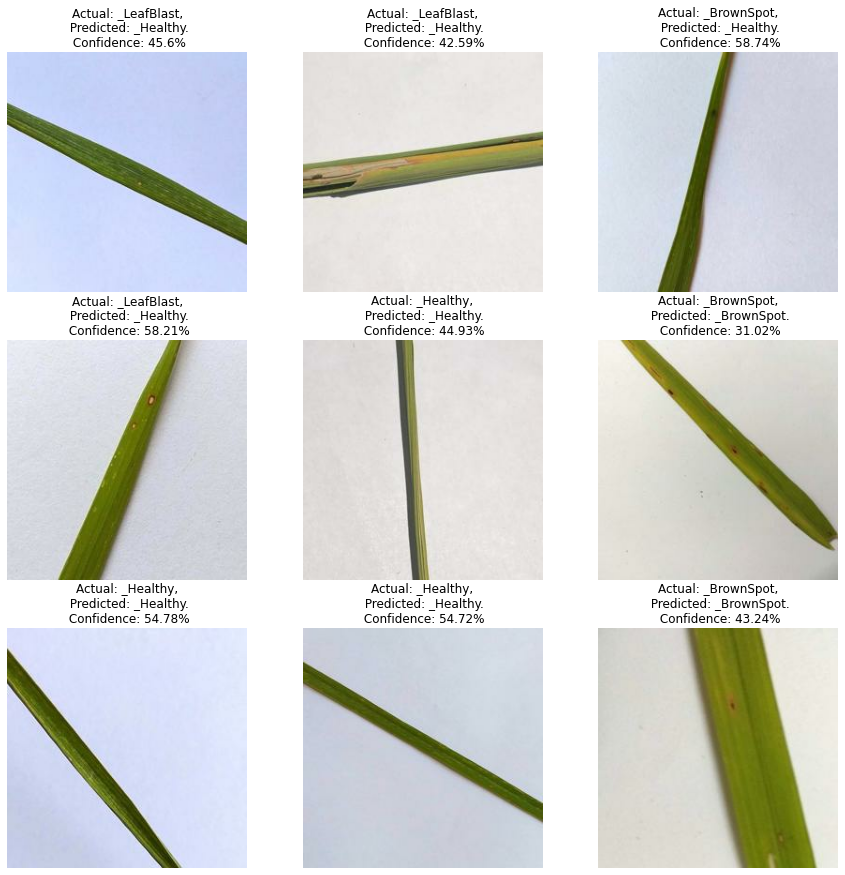

In [100]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%") #using python format string
        
        plt.axis("off")

In [101]:
model_version = 1
model.save(f"rice_models/{model_version}")

INFO:tensorflow:Assets written to: rice_models/1\assets


In [107]:
#use os to automate version save
import os
model_version = max([int(i) for i in os.listdir("rice_models") + [0]])+1 #convert list to integer with list comprehension. 
model.save(f"rice_models/{model_version}")

INFO:tensorflow:Assets written to: rice_models/2\assets
